In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.metrics.pairwise import cosine_similarity


In [10]:
links_df = pd.read_csv("../Data/sävsjö_links.csv", delimiter=';')
articles_df = pd.read_csv("../Data/sävsjö_articles.csv")

In [11]:
# load numpy array from npy file
from numpy import load
# load array
data = load('sentence_embeddingsv2.npy')
# print the array
print(data)

[[-0.5933311  -0.18265206 -0.18915027 ...  0.23665312  0.78490025
   0.21543747]
 [ 0.21236032  0.31227872  0.22370076 ... -0.25148907  0.30309078
   0.25101122]
 [-0.558921   -0.2906208   0.08355109 ...  0.04057155  0.73291266
  -0.10988649]
 ...
 [-0.31250098 -0.22197773 -0.41341496 ... -0.05273872  0.34888843
  -0.36865178]
 [ 0.10391018 -1.2744927  -0.41148    ... -0.63860166  0.7900625
  -0.82006323]
 [-0.11578982 -1.4671689  -0.71534556 ... -0.63776386  1.0241586
  -0.28924334]]


In [12]:
#retrieve tags that are associated with an article in articles_df
existing_links = links_df[links_df['ad_id'].isin(articles_df['ID'].tolist())]

In [13]:
#unique article ids
len(existing_links['ad_id'].unique())

554

In [14]:
existing_links

,ad_id,tag_id
0,85801,169
1,85801,170
2,85801,171
3,85801,172
4,85801,173
...,...,...
2126,255366,111
2127,255366,573
2128,255392,1160
2129,255392,1159


In [15]:
len(links_df)

2151

In [16]:
#retrieve tags with highest frequency
tags_freq_gb = existing_links.groupby('tag_id').size().reset_index()
tags_freq_gb.rename(columns={0: 'count'}, inplace= True)
tags_freq_df = tags_freq_gb.sort_values('count', ascending=False).reset_index(drop = True)

In [17]:
tags_freq_df

,tag_id,count
0,658,46
1,659,46
2,760,38
3,786,32
4,785,31
...,...,...
799,489,1
800,488,1
801,487,1
802,486,1


In [18]:
sorted_tag_ids = tags_freq_df['tag_id'].tolist()

In [19]:
# sorted_tag_ids

In [20]:
#cosine similarities of all articles
data_cos_sim = cosine_similarity(data)

In [36]:
avg_all_above = 0
for tag_id in sorted_tag_ids:
    #retrieving article ids with the current tag
    article_ids = links_df[links_df['tag_id'] == tag_id]['ad_id'].tolist()
    #retrieve index of each article_id from articles_df
    articles_index = articles_df[articles_df['ID'].isin(article_ids)].index.tolist()
    if len(articles_index) <=1:
        continue
    #cross check articles with the same tag and their cosine similarity
    article_cos_sim = data_cos_sim[articles_index[0]]

    #min_score refers to the lowest cosine similarity score amongst the articles that have the same tag 658
    min_score = 1
    avg_score = 0
    for index in articles_index:
    #     print('Cosine Similarity Score:',article_cos_sim[index])
        if article_cos_sim[index] < min_score:
            min_score = article_cos_sim[index]
        avg_score+= article_cos_sim[index]
    avg_score/= len(articles_index)
    if min_score ==1:
        continue
    #get rank of the lowest score
    article_cos_sim_sorted = sorted(article_cos_sim)

    #higher rank = higher percentile
    rank = article_cos_sim_sorted.index(min_score)
    for i in range(len(article_cos_sim_sorted)-1):
        if avg_score >= article_cos_sim_sorted[i] and avg_score <= article_cos_sim_sorted[i+1]:
            rank_avg = i
            break
    #percentile
    percentile = rank/(len(articles_df))
    percentile_avg = rank_avg/(len(articles_df))
    print("All articles with Tag", tag_id,"are aboove the Percentile:",percentile*100)
    print("Percentile of Averaged Cosine Similarity Scores for articles with Tag", tag_id,":",percentile_avg*100)
    print()
    avg_all_above += percentile
avg_all_above = avg_all_above / len(sorted_tag_ids)
print(f'Avg all above percentile across all tags: {avg_all_above*100}')

All articles with Tag 658 are aboove the Percentile: 19.349215572341663
Percentile of Averaged Cosine Similarity Scores for articles with Tag 658 : 94.46833236490413

All articles with Tag 659 are aboove the Percentile: 19.349215572341663
Percentile of Averaged Cosine Similarity Scores for articles with Tag 659 : 94.46833236490413

All articles with Tag 760 are aboove the Percentile: 31.5514235909355
Percentile of Averaged Cosine Similarity Scores for articles with Tag 760 : 81.87100522951772

All articles with Tag 786 are aboove the Percentile: 48.64613596746078
Percentile of Averaged Cosine Similarity Scores for articles with Tag 786 : 81.18535735037769

All articles with Tag 785 are aboove the Percentile: 48.64613596746078
Percentile of Averaged Cosine Similarity Scores for articles with Tag 785 : 81.1040092969204

All articles with Tag 829 are aboove the Percentile: 48.64613596746078
Percentile of Averaged Cosine Similarity Scores for articles with Tag 829 : 80.97617664148751

All 

100533    16
88602     13
120793    11
207231    10
87965     10
105324     9
112169     9
182457     9
87810      9
179598     9
134100     9
86942      9
101712     8
181544     8
90350      8
85896      8
91723      8
93404      8
86873      7
105623     7
Name: ad_id, dtype: int64


<AxesSubplot:>

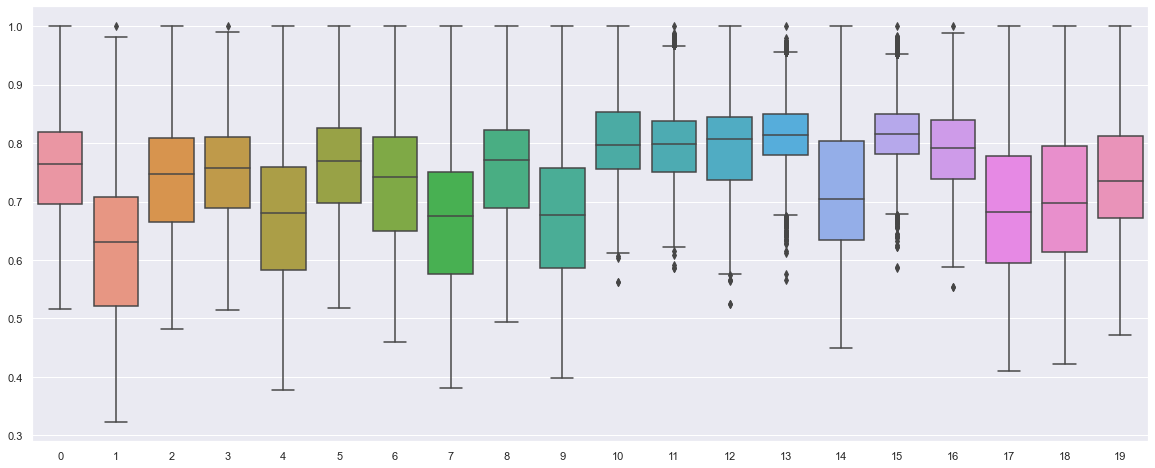

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

unique_existing_links = existing_links.drop_duplicates()
link_counts = unique_existing_links['ad_id'].value_counts()
high_link_ids = link_counts.head(20)
print(high_link_ids)
high_existing_links = unique_existing_links[unique_existing_links['ad_id'].isin(high_link_ids.index.tolist())]
#print(high_existing_links)

linked_arts = articles_df.loc[articles_df['ID'].isin(high_link_ids.index.tolist())]
data_cos_sim_linked = np.take(data_cos_sim, np.unique(linked_arts.index.tolist()), axis=1)

sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(data=data_cos_sim_linked)

In [14]:
# tag_id = 658
# article_ids = links_df[links_df['tag_id'] == tag_id]['ad_id'].tolist()


In [15]:
# article_ids

In [16]:
#retrieve index of each article_id from articles_df
# articles_index = articles_df[articles_df['ID'].isin(article_ids)].index.tolist()

In [17]:
# articles_index

In [18]:
# #cross check articles with the same tag and their cosine similarity
# #checking tag 658
# article_cos_sim = data_cos_sim[articles_index[0]] 

# min_score = 1
# for index in articles_index:
# #     print('Cosine Similarity Score:',article_cos_sim[index])
#     if article_cos_sim[index] < min_score:
#         min_score = article_cos_sim[index]

In [19]:
#min_score refers to the lowest cosine similarity score amongst the articles that have the same tag 658
# min_score

In [20]:
# #get rank of the lowest score
# article_cos_sim_sorted = sorted(article_cos_sim)

# #higher rank = higher percentile
# rank = article_cos_sim_sorted.index(min_score)
# print(rank)

In [21]:
# article_cos_sim_sorted[2]

In [22]:
# #percentile
# percentile = rank/(len(articles_df))
# print(percentile)

In [23]:
# swedish_stopwords = stopwords.words('swedish')
# #tokenizer for punctuation
# regex_tokenizer = RegexpTokenizer(r'\w+')
# # Load pre-trained model tokenizer (data must be tokenized the same way the model is used)
# tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased")
# # tokenised_data = tokenizer(articles_df['Text'].tolist())

# #loading pretrained model
# model = AutoModel.from_pretrained("KB/bert-base-swedish-cased", output_hidden_states=True)

In [24]:
# tokenised_data.tokens

In [25]:
# tokenised_data[0].tokens

In [26]:
# len(tensors['input_ids'])
# tensors

In [27]:
# #use only when needed to regenerate sentence embeddings
# import torch
# from tqdm.notebook import tqdm, trange
# # # Put the model in "evaluation" mode, meaning feed-forward operation.
# model.eval()
# sentence_embeddings = []
# MAX_TOKENS = 512

# for i in trange(len(articles_df['Text'])):
#     article_text = articles_df['Text'].iloc[i]
#     word_tokens = regex_tokenizer.tokenize(article_text)
#     filtered_sentence = " ".join([w for w in word_tokens if not w.lower() in swedish_stopwords])
#     filtered_sentence = "[CLS] " + filtered_sentence + " [SEP]"
#     tokenized_article = tokenizer.tokenize(filtered_sentence)
#     indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_article)
#     if len(indexed_tokens) > MAX_TOKENS:
#         #first 511 tokens are retained
#         del indexed_tokens[MAX_TOKENS-1:]
#         #3 is appended as it represents the separation character [SEP] which marks the end of a sentence, 512th token
#         indexed_tokens.append(3)
#     segments_ids = [[1] * len(indexed_tokens)]
#     # Convert inputs to PyTorch tensors
#     tokens_tensor = torch.tensor([indexed_tokens])
#     segments_tensors = torch.tensor(segments_ids)
#     # Predict hidden states features for each layer
#     with torch.no_grad():
#         outputs = model(tokens_tensor, segments_tensors)
#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
#         hidden_states = outputs[2]
#     # `hidden_states` has shape [13 x 1 x len(segments_id[0]) x 768]
#     # `token_vecs` is a tensor with shape [len(segments_id[0]) x 768]
#     token_vecs = hidden_states[-2][0]

#     # Calculate the average of all 22 token vectors.
#     #convert tensor to np array with .numpy
#     sentence_embedding = torch.mean(token_vecs, dim=0).numpy()
#     sentence_embeddings.append(sentence_embedding)

In [28]:
# #DO NOT USE THIS
# import torch
# from tqdm.notebook import tqdm, trange
# # # Put the model in "evaluation" mode, meaning feed-forward operation.
# model.eval()
# sentence_embeddings = []
# MAX_TOKENS = 512
# tensors = tokenised_data.convert_to_tensors()

# for i in trange(len(tensors['input_ids'])):
#     indexed_tokens = [tensors['input_ids'][i]]
#     if len(indexed_tokens[0]) > MAX_TOKENS:
#         #first 511 tokens are retained
#         del indexed_tokens[0][MAX_TOKENS-1:]
#         #3 is appended as it represents the separation character [SEP] which marks the end of a sentence, 512th token
#         indexed_tokens[0].append(3)
#     segments_ids = [[1] * len(indexed_tokens[0])]
#     # Convert inputs to PyTorch tensors
#     tokens_tensor = torch.tensor(indexed_tokens)
#     segments_tensors = torch.tensor(segments_ids)
#     # Predict hidden states features for each layer
#     with torch.no_grad():
#         outputs = model(tokens_tensor, segments_tensors)
#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
#         hidden_states = outputs[2]
#     # `hidden_states` has shape [13 x 1 x 22 x 768]
#     # `token_vecs` is a tensor with shape [22 x 768]
#     token_vecs = hidden_states[-2][0]

#     # Calculate the average of all 22 token vectors.
#     #convert tensor to np array with .numpy
#     sentence_embedding = torch.mean(token_vecs, dim=0).numpy()
#     sentence_embeddings.append(sentence_embedding)

In [29]:
# # save numpy array as npy file
# from numpy import asarray
# from numpy import save
# # define data
# data = asarray(sentence_embeddings)
# # save to npy file
# save('sentence_embeddingsv3.npy', data)